In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from cern_utils import plot_feature_importance
from sklearn.metrics import roc_auc_score,auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
plt.style.use('seaborn')

In [3]:
train = pd.read_csv("train.csv", index_col="Id")
test = pd.read_csv("test.csv", index_col="Id")
train = train.drop(columns="BUTTER")
test = test.drop(columns="BUTTER")

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(
    train.drop(columns="signal"), train.signal, stratify=train.signal
)

## Catboost

In [5]:
cb = CatBoostClassifier(verbose=0, eval_metric="AUC", iterations=200)
cb.fit(X_tr, y_tr)

In [6]:
print("train", roc_auc_score(cb.predict(X_tr), y_tr))
print("test", roc_auc_score(cb.predict(X_te), y_te))

train 0.7987503989032728
test 0.7704949954528848


14 features, reduction of 0.00%


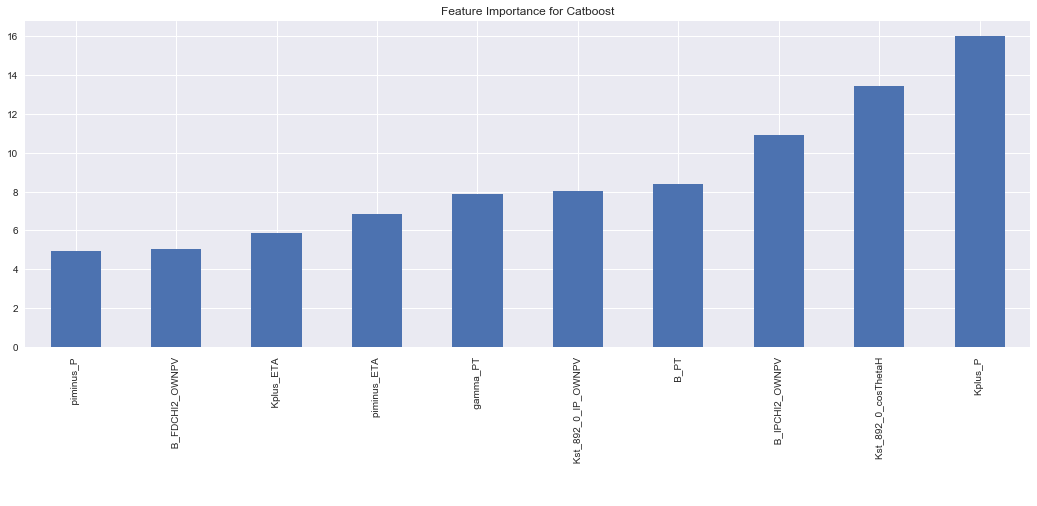

In [7]:
plot_feature_importance(X_tr.columns,cb.get_feature_importance())

## Xgb

In [8]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
print("train", roc_auc_score(xgb.predict(X_tr), y_tr))
print("test", roc_auc_score(xgb.predict(X_te), y_te))

train 0.8089790528983948
test 0.7635864847756737


## Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_tr,y_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
print('train',roc_auc_score(rf.predict(X_tr),y_tr))
print('test',roc_auc_score(rf.predict(X_te),y_te))

train 0.9884625725274073
test 0.7198846538251973


## Voting Classifier

In [13]:
vc = VotingClassifier(estimators=[("cb", cb), ("xgb", xgb), ("rf", rf)], voting="soft")

In [14]:
vc.fit(X_tr, y_tr)

VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x7fab9a3add10>),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, miss...
                                                     criterion='gini',
                                                     max_depth=None,
                                              

In [15]:
print('train',roc_auc_score(vc.predict(X_tr),y_tr))
print('test',roc_auc_score(vc.predict(X_te),y_te))

train 0.9068278581245671
test 0.7657542567926574
